# Homework 4
Evelina Teran & Kevin Smith

In [143]:
import numpy as np
import pandas as pd
import platform
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

## Question 1

The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.


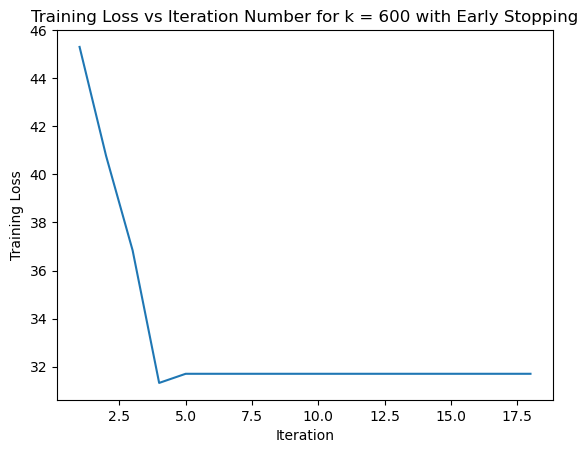

     k  Train Error  Test Error
0   10         0.50        0.48
1   30         0.42        0.45
2  100         0.42        0.45
3  300         0.42        0.45
4  600         0.42        0.45


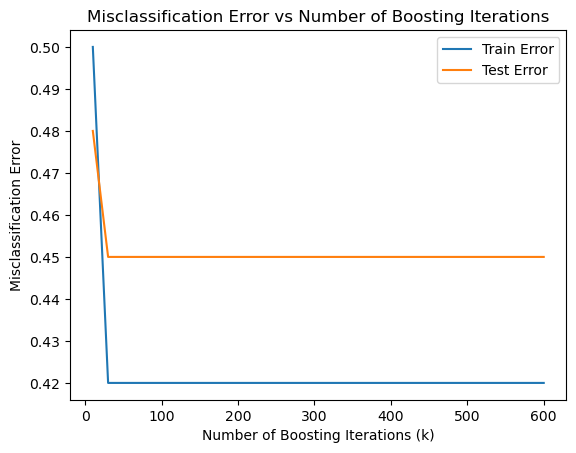

<Figure size 1000x800 with 0 Axes>

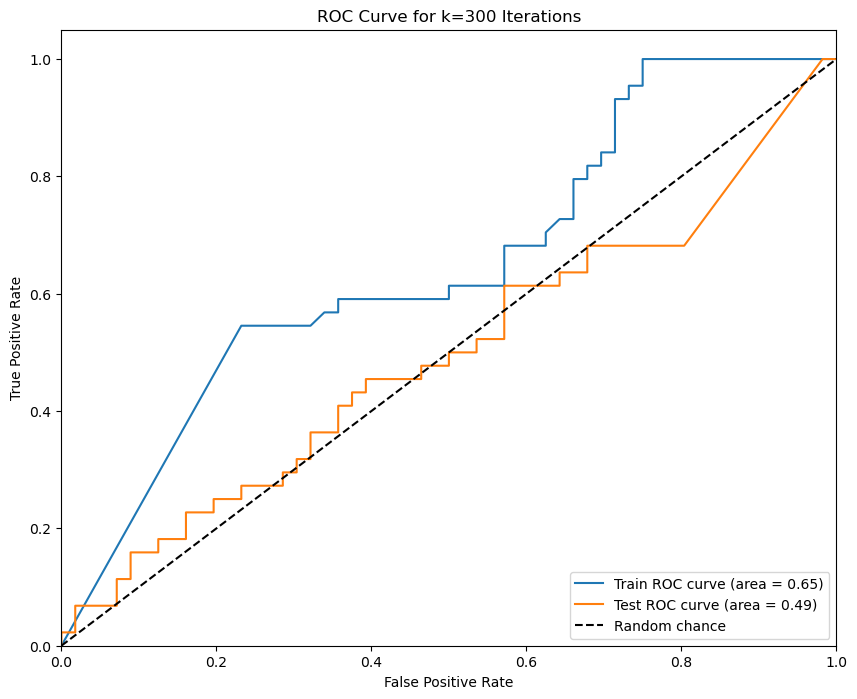

{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

In [144]:
def loss_function(y, pred):
    y = 2 * y - 1  # Ensure y is in the form of -1 or 1
    # Use a numerically stable version of the logistic loss
    log_exp = np.log(1 + np.exp(-y * pred))
    # Handle large values explicitly to avoid overflow
    stable_log_exp = np.where(pred * y > 0, np.maximum(0, log_exp), log_exp + pred * y)
    return np.sum(stable_log_exp)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_roc_curve(y_true, y_score, label_prefix):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label_prefix} ROC curve (area = {roc_auc:.2f})')


old_settings = np.seterr(over='ignore')

data_direc = os.getcwd() + "/"
if platform.system() == "Windows":
    data_direc = data_direc.replace("/", "\\")
train = pd.read_csv(data_direc + "arcene_train.csv",header = None)
true_train_labels = pd.read_csv(data_direc + "arcene_train_labels.csv")
test = pd.read_csv(data_direc + "arcene_valid.csv",header = None)
test_labels = pd.read_csv(data_direc + "arcene_valid_labels.csv")

# Normalize the data
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train))
test = pd.DataFrame(scaler.transform(test))

# Define parameters
k_values = [10,30,100,300,600]
class_probabilities = np.zeros(len(true_train_labels)).reshape(-1, 1)

# Initialize lists to store results
train_losses = []
test_losses = []
train_errors = []
test_errors = []
best_lin_models = []
test_class_probabilities = np.zeros(test.shape[0]).reshape(-1, 1)
selected_features_indices = []
losses_per_k = []
train_prob_300 = None
test_prob_300 = None


train_labels = (true_train_labels + 1) / 2

for k in k_values:
    consecutive_count = 0
    train_losses_iter = []
    class_probabilities = np.zeros(len(true_train_labels)).reshape(-1, 1)
    active_features = set(range(train.shape[1]))
    temp_losses = []
    for _ in range(k):
        best_loss = float('inf')
        for feature_idx in active_features:
            # Fit univariate linear regressor
            X_feature = np.array(train.iloc[:, feature_idx]).reshape(-1, 1)
            exp_term = -1*np.array(class_probabilities)
            p = np.ones(len(train_labels)).reshape(-1,1) / (np.ones(len(train_labels)).reshape(-1,1) + np.exp(exp_term))
            epsilon = 1e-6
            w = np.clip(p * (1 - p), epsilon, np.inf)
            z = (train_labels - p) / w
            
            temp_x = X_feature * w.reshape(-1, 1)  # Reshape w to match the shape of X_feature
            lr = LinearRegression().fit(temp_x, z)
            pred = lr.predict(X_feature)
            pred = sigmoid(pred)

            # Calculate loss
            loss = loss_function(train_labels, pred)
            if loss < best_loss:
                best_loss_index = feature_idx
                #print("better :)")
                best_loss = loss
                best_predictor = lr

        temp_losses.append(best_loss)
        best_lin_models.append(lr)
        active_features.remove(best_loss_index)
        class_probabilities += best_predictor.predict(np.array(train.iloc[:, best_loss_index]).reshape(-1,1))
        selected_features_indices.append(best_loss_index)
        train_losses_iter.append(loss_function(train_labels, class_probabilities))  # Append the training loss at each iteration

        if len(temp_losses) >= 10 and all(x == temp_losses[-1] for x in temp_losses[-10:]):
            print("The last ten values are the same. Breaking the loop.")
            break
    losses_per_k.append(temp_losses)
        
    
    train_losses.append(train_losses_iter)
    # Calculate training and test loss
    train_loss = loss_function(train_labels, class_probabilities)
    test_loss = loss_function(test_labels, class_probabilities)

    # Calculate training and test error
    train_pred = np.sign(class_probabilities)
    for model, feature_idx in zip(best_lin_models, selected_features_indices):
        current_test_predictions = model.predict(test.iloc[:, feature_idx].values.reshape(-1,1))
        test_class_probabilities += current_test_predictions
    
    if k == 300:
        train_prob_300 = class_probabilities.copy()
        # Ensure test_class_probabilities are updated correctly in the loop
        test_prob_300 = test_class_probabilities.copy()
    

# Determine final predictions for the test set
    test_pred = np.sign(test_class_probabilities)
    train_pred = (train_pred +1)/2
    train_error = 1 - accuracy_score(train_labels, train_pred)
    test_error = 1 - accuracy_score(test_labels, test_pred)
        
    train_losses.append(train_losses_iter)  # Append the list of training losses for this k to train_losses

    test_losses.append(test_loss)
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot training loss vs iteration number for k = 600
plt.plot(range(1, len(losses_per_k[-1])+1), losses_per_k[-1])
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iteration Number for k = 600 with Early Stopping')
plt.show()

# Report misclassification errors on the training and test sets for all values of k
error_table = pd.DataFrame({'k': k_values, 'Train Error': train_errors, 'Test Error': test_errors})
print(error_table)

# Plot misclassification errors on the training and test sets vs k
plt.plot(k_values, train_errors, label='Train Error')
plt.plot(k_values, test_errors, label='Test Error')
plt.xlabel('Number of Boosting Iterations (k)')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Number of Boosting Iterations')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))

if train_prob_300 is not None and test_prob_300 is not None:
    plt.figure(figsize=(10, 8))

    # Plot ROC curve for the training set
    plot_roc_curve(true_train_labels, train_prob_300, 'Train')
    # Plot ROC curve for the test set
    plot_roc_curve(test_labels, test_prob_300, 'Test')

    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for k=300 Iterations')
    plt.legend(loc="lower right")
    plt.show()


np.seterr(**old_settings)

## Question 2

The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.


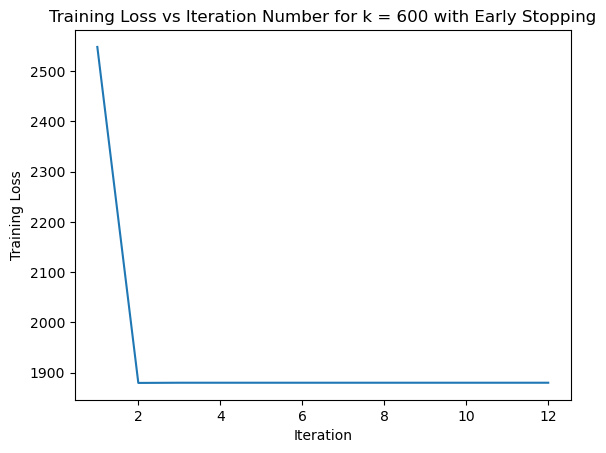

     k  Train Error  Test Error
0   10     0.498667       0.501
1   30     0.498333       0.501
2  100     0.498333       0.501
3  300     0.498333       0.501
4  600     0.498333       0.501


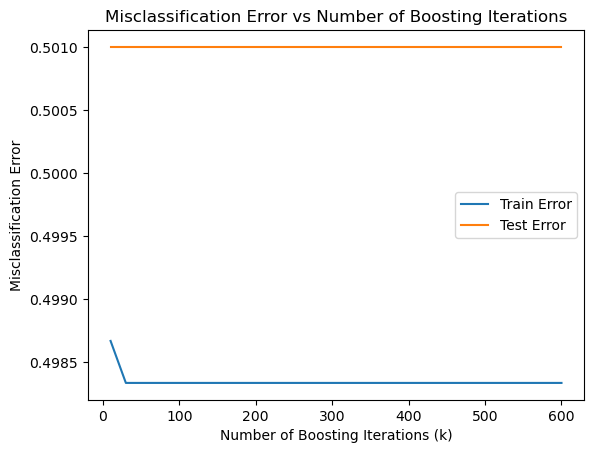

<Figure size 1000x800 with 0 Axes>

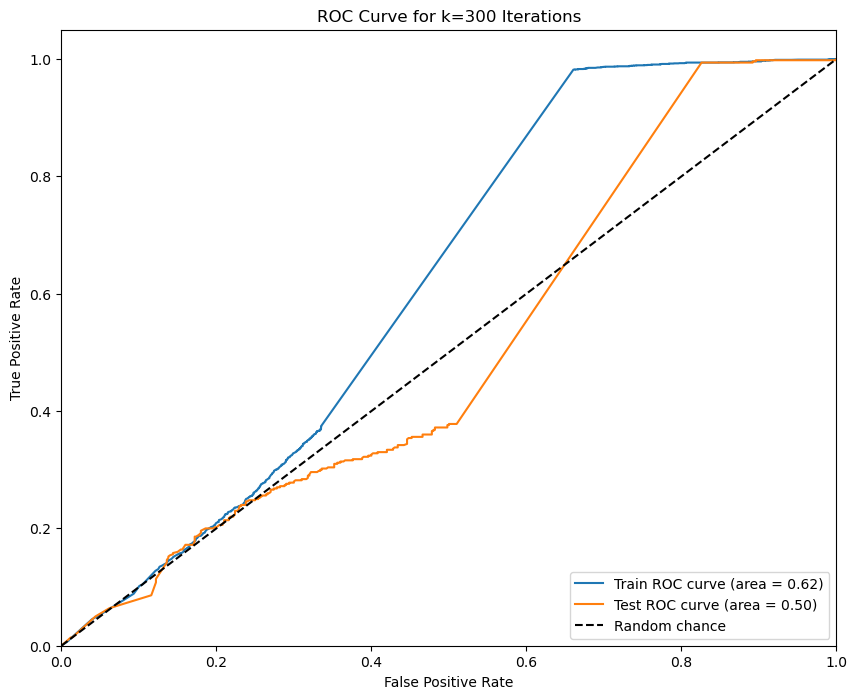

{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

In [145]:
def loss_function(y, pred):
    y = 2 * y - 1  # Ensure y is in the form of -1 or 1
    # Use a numerically stable version of the logistic loss
    log_exp = np.log(1 + np.exp(-y * pred))
    # Handle large values explicitly to avoid overflow
    stable_log_exp = np.where(pred * y > 0, np.maximum(0, log_exp), log_exp + pred * y)
    return np.sum(stable_log_exp)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_roc_curve(y_true, y_score, label_prefix):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label_prefix} ROC curve (area = {roc_auc:.2f})')


data_direc = os.getcwd() + "/"
if platform.system() == "Windows":
    data_direc = data_direc.replace("/", "\\")
train = pd.read_csv(data_direc + "gisette_train.csv")
train_labels = pd.read_csv(data_direc + "gisette_train_labels.csv")
test = pd.read_csv(data_direc + "gisette_valid.csv")
test_labels = pd.read_csv(data_direc + "gisette_valid_labels.csv")
train = np.delete(train, 5000, axis=1)
test = np.delete(test, 5000, axis=1)

old_settings = np.seterr(over='ignore')

true_train_labels = train_labels

# Normalize the data
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train))
test = pd.DataFrame(scaler.transform(test))

# Define parameters
k_values = [10,30,100,300,600]
class_probabilities = np.zeros(len(true_train_labels)).reshape(-1, 1)

# Initialize lists to store results
train_losses = []
test_losses = []
train_errors = []
test_errors = []
best_lin_models = []
test_class_probabilities = np.zeros(test.shape[0]).reshape(-1, 1)
selected_features_indices = []
losses_per_k = []
train_prob_300 = None
test_prob_300 = None


for k in k_values:
    consecutive_count = 0
    train_losses_iter = []
    class_probabilities = np.zeros(len(true_train_labels)).reshape(-1, 1)
    active_features = set(range(train.shape[1]))
    temp_losses = []
    for _ in range(k):
        best_loss = float('inf')
        for feature_idx in active_features:
            # Fit univariate linear regressor
            X_feature = np.array(train.iloc[:, feature_idx]).reshape(-1, 1)
            exp_term = -1*np.array(class_probabilities)
            p = np.ones(len(train_labels)).reshape(-1,1) / (np.ones(len(train_labels)).reshape(-1,1) + np.exp(exp_term))
            epsilon = 1e-6
            w = np.clip(p * (1 - p), epsilon, np.inf)
            z = (train_labels - p) / w
            
            temp_x = X_feature * w.reshape(-1, 1)  # Reshape w to match the shape of X_feature
            lr = LinearRegression().fit(temp_x, z)
            pred = lr.predict(X_feature)
            pred = sigmoid(pred)

            # Calculate loss
            loss = loss_function(train_labels, pred)
            if loss < best_loss:
                best_loss_index = feature_idx
                #print("better :)")
                best_loss = loss
                best_predictor = lr

        temp_losses.append(best_loss)
        best_lin_models.append(lr)
        active_features.remove(best_loss_index)
        class_probabilities += best_predictor.predict(np.array(train.iloc[:, best_loss_index]).reshape(-1,1))
        selected_features_indices.append(best_loss_index)
        train_losses_iter.append(loss_function(train_labels, class_probabilities))  # Append the training loss at each iteration

        if len(temp_losses) >= 10 and all(x == temp_losses[-1] for x in temp_losses[-10:]):
            print("The last ten values are the same. Breaking the loop.")
            break
    losses_per_k.append(temp_losses)
        
    
    train_losses.append(train_losses_iter)
    # Calculate training and test loss
    train_loss = loss_function(train_labels, class_probabilities)
    

    # Calculate training and test error
    train_pred = np.sign(class_probabilities)
    for model, feature_idx in zip(best_lin_models, selected_features_indices):
        current_test_predictions = model.predict(test.iloc[:, feature_idx].values.reshape(-1,1))
        test_class_probabilities += current_test_predictions
    test_loss = loss_function(test_labels, test_class_probabilities)
    
    if k == 300:
        train_prob_300 = class_probabilities.copy()
        # Ensure test_class_probabilities are updated correctly in the loop
        test_prob_300 = test_class_probabilities.copy()
    

# Determine final predictions for the test set
    test_pred = np.sign(test_class_probabilities)
    train_pred = (train_pred +1)/2
    train_error = 1 - accuracy_score(train_labels, train_pred)
    test_error = 1 - accuracy_score(test_labels, test_pred)
        
    train_losses.append(train_losses_iter)  # Append the list of training losses for this k to train_losses

    test_losses.append(test_loss)
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot training loss vs iteration number for k = 600
plt.plot(range(1, len(losses_per_k[-1])+1), losses_per_k[-1])
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iteration Number for k = 600 with Early Stopping')
plt.show()

# Report misclassification errors on the training and test sets for all values of k
error_table = pd.DataFrame({'k': k_values, 'Train Error': train_errors, 'Test Error': test_errors})
print(error_table)

# Plot misclassification errors on the training and test sets vs k
plt.plot(k_values, train_errors, label='Train Error')
plt.plot(k_values, test_errors, label='Test Error')
plt.xlabel('Number of Boosting Iterations (k)')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Number of Boosting Iterations')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))

if train_prob_300 is not None and test_prob_300 is not None:
    plt.figure(figsize=(10, 8))

    # Plot ROC curve for the training set
    plot_roc_curve(true_train_labels, train_prob_300, 'Train')
    # Plot ROC curve for the test set
    plot_roc_curve(test_labels, test_prob_300, 'Test')

    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for k=300 Iterations')
    plt.legend(loc="lower right")
    plt.show()


np.seterr(**old_settings)

## Question 3

The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.
The last ten values are the same. Breaking the loop.


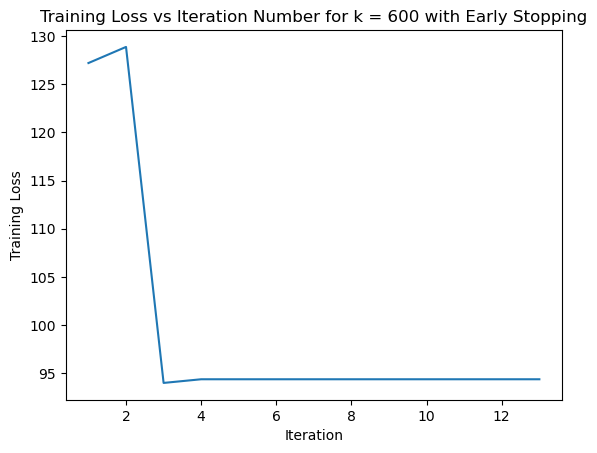

     k  Train Error  Test Error
0   10     0.476667    0.486667
1   30     0.466667    0.486667
2  100     0.466667    0.486667
3  300     0.466667    0.486667
4  600     0.466667    0.486667


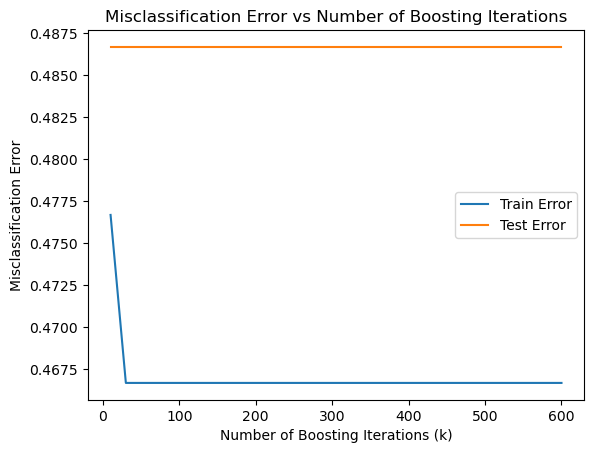

<Figure size 1000x800 with 0 Axes>

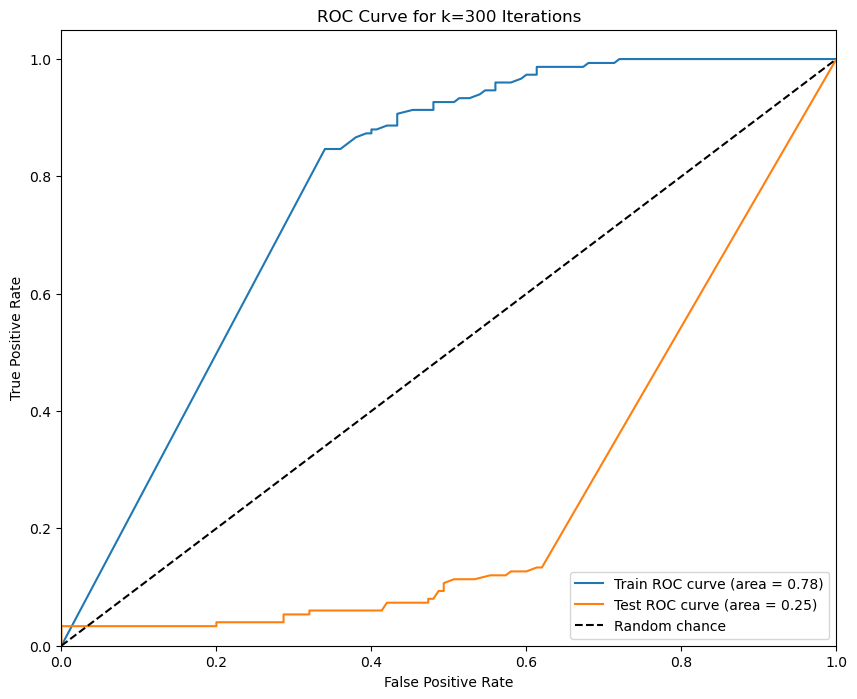

{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

In [148]:
train = pd.read_csv(data_direc + "dexter_train.csv", header = None)
train_labels = pd.read_csv(data_direc + "dexter_train_labels.csv", header = None)
test = pd.read_csv(data_direc + "dexter_valid.csv", header = None)
test_labels = pd.read_csv(data_direc + "dexter_valid_labels.csv", header = None)
true_train_labels = train_labels

old_settings = np.seterr(over='ignore')

train_labels = (true_train_labels + 1) / 2

# Normalize the data
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train))
test = pd.DataFrame(scaler.transform(test))

# Define parameters
k_values = [10,30,100,300,600]
class_probabilities = np.zeros(len(true_train_labels)).reshape(-1, 1)

# Initialize lists to store results
train_losses = []
test_losses = []
train_errors = []
test_errors = []
best_lin_models = []
test_class_probabilities = np.zeros(test.shape[0]).reshape(-1, 1)
selected_features_indices = []
losses_per_k = []
train_prob_300 = None
test_prob_300 = None


for k in k_values:
    consecutive_count = 0
    train_losses_iter = []
    class_probabilities = np.zeros(len(true_train_labels)).reshape(-1, 1)
    active_features = set(range(train.shape[1]))
    temp_losses = []
    for _ in range(k):
        best_loss = float('inf')
        for feature_idx in active_features:
            # Fit univariate linear regressor
            X_feature = np.array(train.iloc[:, feature_idx]).reshape(-1, 1)
            exp_term = -1*np.array(class_probabilities)
            p = np.ones(len(train_labels)).reshape(-1,1) / (np.ones(len(train_labels)).reshape(-1,1) + np.exp(exp_term))
            epsilon = 1e-6
            w = np.clip(p * (1 - p), epsilon, np.inf)
            z = (train_labels - p) / w
            
            temp_x = X_feature * w.reshape(-1, 1)  # Reshape w to match the shape of X_feature
            lr = LinearRegression().fit(temp_x, z)
            pred = lr.predict(X_feature)
            pred = sigmoid(pred)

            # Calculate loss
            loss = loss_function(train_labels, pred)
            if loss < best_loss:
                best_loss_index = feature_idx
                #print("better :)")
                best_loss = loss
                best_predictor = lr

        temp_losses.append(best_loss)
        best_lin_models.append(lr)
        active_features.remove(best_loss_index)
        class_probabilities += best_predictor.predict(np.array(train.iloc[:, best_loss_index]).reshape(-1,1))
        selected_features_indices.append(best_loss_index)
        train_losses_iter.append(loss_function(train_labels, class_probabilities))  # Append the training loss at each iteration

        if len(temp_losses) >= 10 and all(x == temp_losses[-1] for x in temp_losses[-10:]):
            print("The last ten values are the same. Breaking the loop.")
            break
    losses_per_k.append(temp_losses)
        
    
    train_losses.append(train_losses_iter)
    # Calculate training and test loss
    train_loss = loss_function(train_labels, class_probabilities)
    

    # Calculate training and test error
    train_pred = np.sign(class_probabilities)
    for model, feature_idx in zip(best_lin_models, selected_features_indices):
        current_test_predictions = model.predict(test.iloc[:, feature_idx].values.reshape(-1,1))
        test_class_probabilities += current_test_predictions
    test_loss = loss_function(test_labels, test_class_probabilities)
    
    if k == 300:
        train_prob_300 = class_probabilities.copy()
        # Ensure test_class_probabilities are updated correctly in the loop
        test_prob_300 = test_class_probabilities.copy()
    

# Determine final predictions for the test set
    test_pred = np.sign(test_class_probabilities)
    train_pred = (train_pred +1)/2
    train_error = 1 - accuracy_score(train_labels, train_pred)
    test_error = 1 - accuracy_score(test_labels, test_pred)
        
    train_losses.append(train_losses_iter)  # Append the list of training losses for this k to train_losses

    test_losses.append(test_loss)
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot training loss vs iteration number for k = 600
plt.plot(range(1, len(losses_per_k[-1])+1), losses_per_k[-1])
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iteration Number for k = 600 with Early Stopping')
plt.show()

# Report misclassification errors on the training and test sets for all values of k
error_table = pd.DataFrame({'k': k_values, 'Train Error': train_errors, 'Test Error': test_errors})
print(error_table)

# Plot misclassification errors on the training and test sets vs k
plt.plot(k_values, train_errors, label='Train Error')
plt.plot(k_values, test_errors, label='Test Error')
plt.xlabel('Number of Boosting Iterations (k)')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Number of Boosting Iterations')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))

if train_prob_300 is not None and test_prob_300 is not None:
    plt.figure(figsize=(10, 8))

    # Plot ROC curve for the training set
    plot_roc_curve(true_train_labels, train_prob_300, 'Train')
    # Plot ROC curve for the test set
    plot_roc_curve(test_labels, test_prob_300, 'Test')

    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for k=300 Iterations')
    plt.legend(loc="lower right")
    plt.show()


np.seterr(**old_settings)


